In [ ]:
# Katarzyna Życieńska

# Imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from scipy.interpolate import interp1d
import os
import pandas as pd
import random
import scipy

# Import distribution from NTA

In [12]:
def importuj_rozklady_NTA(dir =  './NTA_csv/'):
  files = os.listdir(dir)
  slownik_nta = {}
  for file in files:
    df = pd.read_csv(dir+file,  header=None, sep=";",decimal=",", dtype=np.float64)
    calka = np.cumsum(df[1])
    slownik_nta[file[:-4]]=[np.array(df[0]), np.array(df[1])]
  return slownik_nta

def normalizuj(x, y):
  x = np.array(x)
  y = np.array(y)
  calka = np.sum(0.5*(y[0:-1]+y[1:])*(x[1:]-x[0:-1]))
  y = y/calka
  return x, y

def zwroc_rozklad_NTA(lista,ile_pecherzykow = 10**4,  dir = './NTA_csv/'):
  slownik_nta = importuj_rozklady_NTA(dir)
  x_new = np.linspace(20, 400, num=10000, endpoint=True)
  y_new = np.zeros(x_new.shape)
  licznik = 0

  for dane in lista:
    x, y = zip(*sorted(zip(slownik_nta[dane][0], slownik_nta[dane][1])))
    x = np.array(x)
    x, y = normalizuj(x, y)
    f2 = interp1d(x, y)
    y_new += f2(x_new)
    licznik+=1
  y_new/=licznik
  y_new = np.where(y_new<0, 0, y_new)

  sample = random.choices(x_new, y_new, k=ile_pecherzykow) # losuję x z wagami y_new
  return np.array(sample)*10**-9 # in m


# Simulation of Brownian motion

In [13]:
def simulation(lista_probek, N, tmax, g_k=3E-3, krok_t =1, t_pomiarow=[3600, 3600*20]):
  """
  N - number of exosomes

  tmax - time after which the simulation ends (s)

  krok_t - time step (s)

  t_pomiarow -  the time when we want to draw histograms of the diameters of the already attached vesicles
  
  """
  plt.figure(dpi=300)
  eta=1E-3
  T=293
  k_B=1.38E-23

  # losuję średnice z rozkładu, każdy b=pęcherzyk ma losową średnicę
  dk = zwroc_rozklad_NTA(lista_probek,ile_pecherzykow = N)

  # dla każdego pęcherzyka wyznaczam stałą dyfuzji
  Dk=k_B*T/(3*np.pi*eta*dk) #moim zdaniem ta czwórka to jakaś pomyłka

  sig=np.sqrt(2*Dk*krok_t)
  #print(sig)

  xk=np.random.rand(N)*g_k # losuję początkowe wartości 

  # ------------------------
  # przyczepione jako 0 są oznaczone
  przyczepione = np.ones((N))

  # ile przyczepionych jest w danym kroku czasowym:
  ile_przyczepionych=np.zeros(int(tmax/krok_t))

  do_testu=[]

  # Symulacja ------------------------
  for t in range(int(tmax/krok_t)):
    sigk=sig*(np.random.randn(N))
    #xk+= sigk #uwaga! przyczepione dalej się ruszają?
    xk+= sigk*przyczepione
    # jeśli w tym kroku wyszedłby egzosom za rozmiar kropli, to go cofam o tyle o ile wyszedł:
    xk[np.where(xk>g_k)]=2*g_k-xk[np.where(xk>g_k)]

    # jeśli w tym kroku egzosom dotknie podłoża to zeruję go
    przyczepione[np.where(xk<=0)]= 0

    ile_przyczepionych[t] = N - np.sum(przyczepione)
    if len(t_pomiarow)>0:
      if t*krok_t >= t_pomiarow[0]:
        t_pomiarow.pop(0)
        sred_przyczepione = dk[np.where(przyczepione==0)]*10**9 # zamiana na nm
        print(len(sred_przyczepione))
        if t*krok_t >= 3600:
          dlabel = str(t*krok_t/3600)+" h"
        else:
          dlabel = str(t*krok_t/60)+" min"
        plt.hist(sred_przyczepione, label=dlabel, bins=np.arange(0, 400, 10), alpha = 0.5, density=True)
        do_testu.append(np.copy(sred_przyczepione))


  plt.xlabel("Hydrodynamic diameter (nm)")
  plt.ylabel("Probability")
  plt.legend()
  plt.show()

  plt.figure(dpi=300)
  tt=np.arange(int(tmax/krok_t))
  plt.plot(tt*krok_t/3600, ile_przyczepionych/N*100)
  plt.xlabel("Time (h)")
  plt.ylabel("Percentage of attached exosomes (%)")
  plt.show()

  return do_testu[0], do_testu[1]



# Simulation 10^6 exosomes


```
# Drop thickness:
a = 0.5E-2 #radius of the mica substrate in meters
# Drop:
h=1E-3 #drop thickness in meters
h_av=(1/2)*h+(1/6)*(h**3/a**2) #average height value, approximately half the height
g_k= h_av

# -------------------------
# Number of vesicles to simulate:
N=int(1e6)

# Time after which the simulation ends
tmax=3600*21

krok_t=60 # in seconds

after_1h, after_20h = simulation(["202", "322", "422", "161", "461"], N, tmax, g_k, krok_t, t_pomiarow=[3600*1, 3600*20])
```




276621
944556


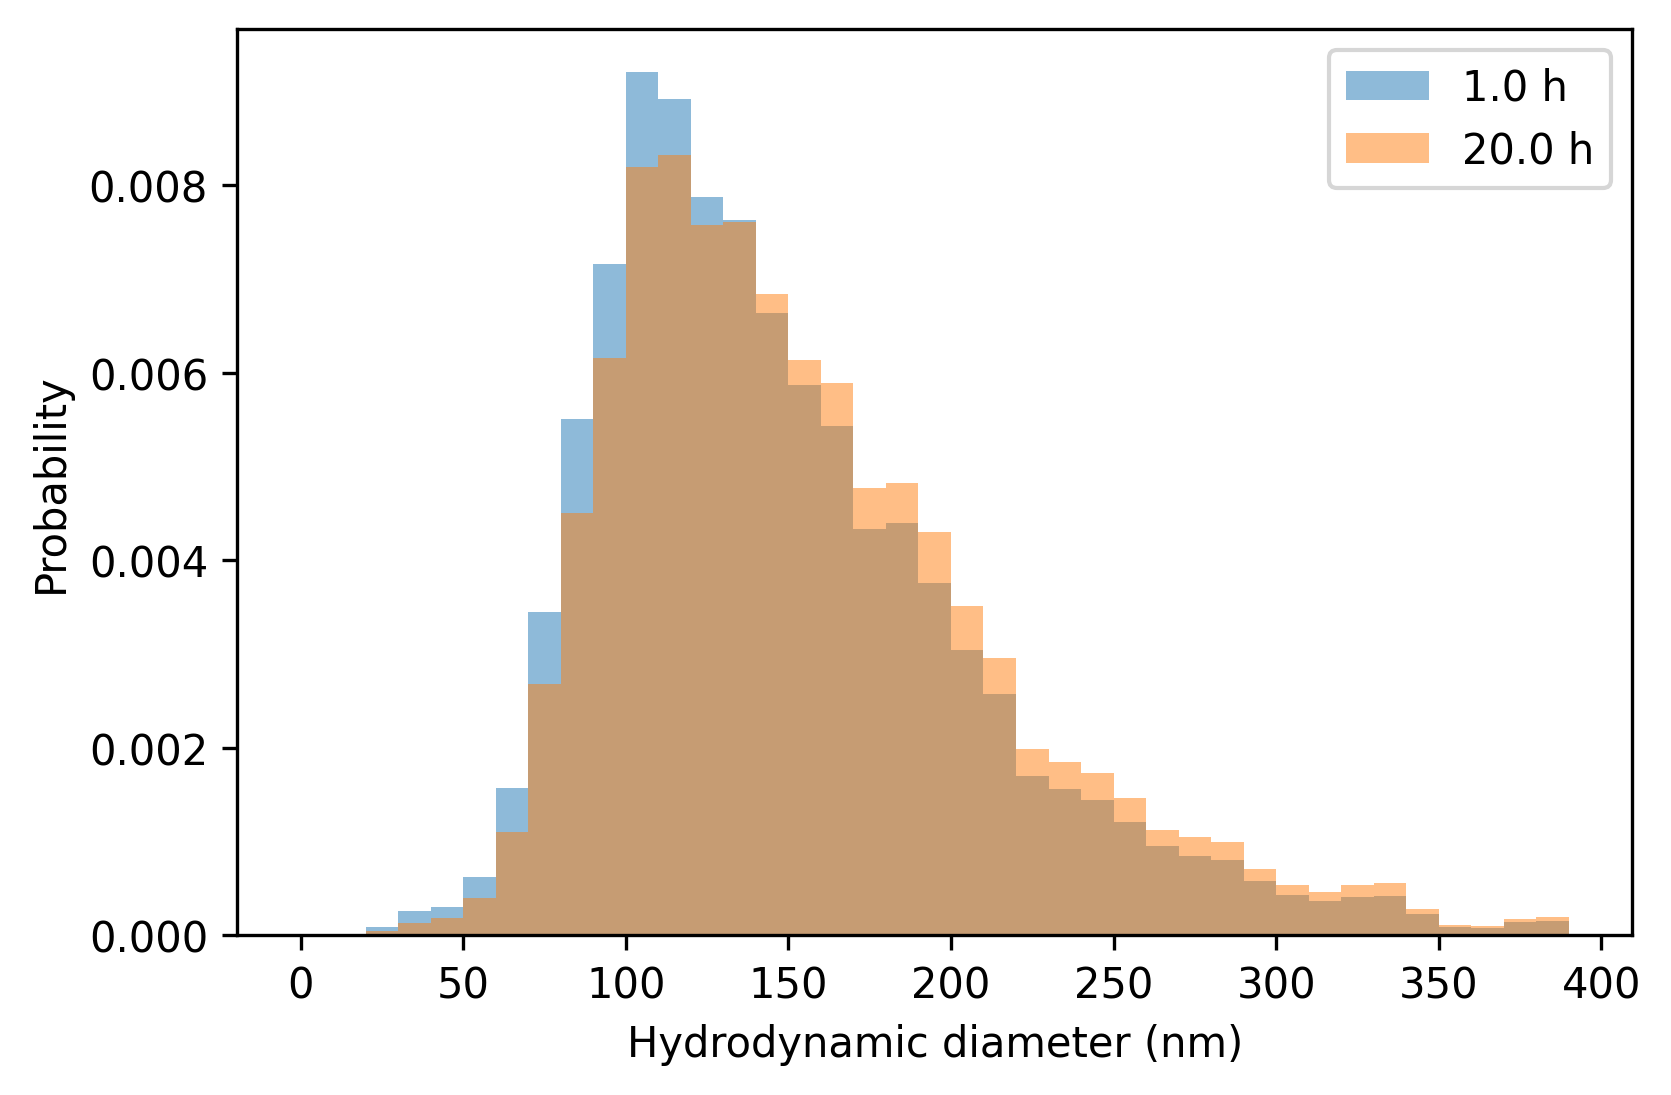

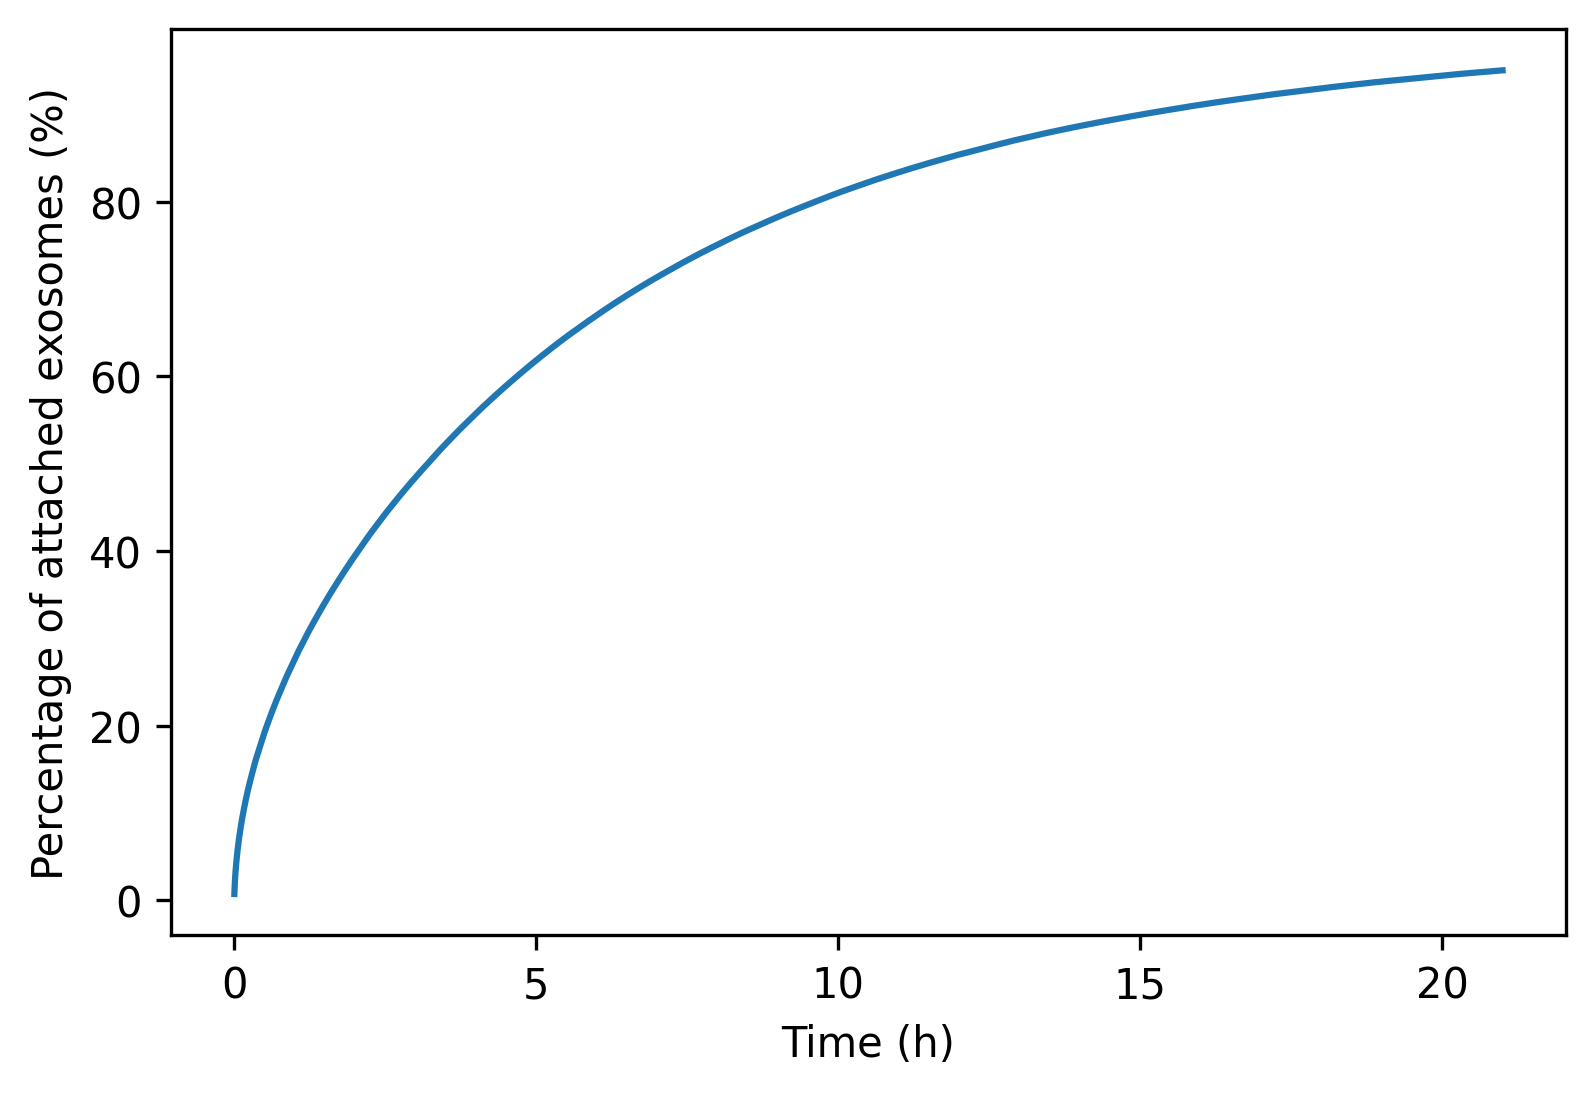

In [15]:
# Drop thickness:
a = 0.5E-2 #radius of the mica substrate in meters
# Drop:
h=1E-3 #drop thickness in meters
h_av=(1/2)*h+(1/6)*(h**3/a**2) #average height value, approximately half the height
g_k= h_av
# Number of vesicles to simulate
N=int(1e6)

# Time after which the simulation ends (s)
tmax=3600*21

#Time step (s)
krok_t=10 # in seconds

#101, 102 and 202 are exosomes NTA from nonirradiotion cells
after_1h, after_20h = simulation(["101", "102", "202"], N, tmax, g_k, krok_t, t_pomiarow=[3600*1, 3600*20])
